In [28]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [14]:
# -- Roemmich and Gilson Argo (load densities ... code to calulate is above) 
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_potential_density_0_400m.nc')
argo_rho = xr.open_dataset(filename)
RGdensity = argo_rho['density'].data
RGlon = argo_rho.lon.longitude.data
RGlat = argo_rho.lat.latitude.data
RGpressure = argo_rho.pressure.pressure.data
# shift RG by longitude 
RG_shift = np.where(RGlon > 360)[0]
RGlon = np.concatenate((np.arange(0.5,20.5,1), RGlon[0:RG_shift[0]]))
RGdensity = np.concatenate((RGdensity[:,:,:,RG_shift], RGdensity[:,:,:,0:RG_shift[0]]), axis=3)

In [35]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

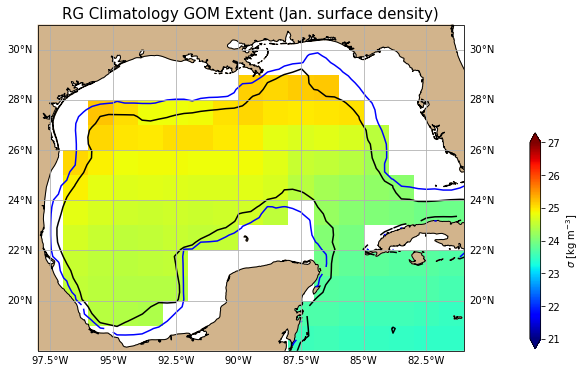

In [42]:
data_coords = {'latitude': RGlat, 'longitude': RGlon}
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
arg_d = xr.DataArray(data=RGdensity[0][0], dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=21, vmax=27, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax.contour(lons,lats,dep,levels=[150],colors='b')
ax.contour(lons,lats,dep,levels=[1000],colors='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_xlim([-98,-81]); ax.set_ylim([18,31]);
ax.set_title('RG Climatology GOM Extent (Jan. surface density)',fontsize=15)
cbpos = [0.90, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label=r'$\sigma$ [kg m$^{-3}$]')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_argo_1000m.jpg', dpi=250)